### Входной анализ данных

In [23]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
import joblib
import random

In [2]:
DATABASE_GAS_PATH = "../data/database_gas.csv"
DATABASE_POS_PATH = "../data/database_pos.csv"
DATABASE_UNINHABITED_HOUSE_PATH = "../data/uninhabited_house.csv"

Проведем входной анализ данных на основе статистических особенностей двух выборок, содержащих данные датчиков за периоды, когда пожилой человек был дома, и когда дом пустовал соответственно.

Кажется логичным, что аномалии в значениях датчиков стоит рассматривать в разрезе часа суток, так как значения, которые типичные, например, днем, могут быть подозрительными для другого времени суток, но в то же время значения датчиков в течение часа не должны сильно разниться, поэтому округлим дату до часа.

Также добавим флаг, рассматриваем ли мы значения датчиков, когда кто-то проживает в доме, либо когда дом пустует.

In [3]:
df_gas = pd.read_csv(DATABASE_GAS_PATH)
df_pos = pd.read_csv(DATABASE_POS_PATH)
df_uninhabited = pd.read_csv(DATABASE_UNINHABITED_HOUSE_PATH)

df_gas['inhabited'] = 0
df_gas.loc[df_gas.timestamp < df_uninhabited.iloc[0].timestamp, 'inhabited'] = 1

df_gas['hour'] = list(map(lambda x : x.hour, pd.to_datetime(df_gas.timestamp)))
df_gas['day'] = list(map(lambda x : x.date(), pd.to_datetime(df_gas.timestamp)))
df_gas.drop('timestamp', axis=1, inplace=True)

### EDA признаков

In [4]:
features = df_gas.columns.tolist()

features.remove('day')
features.remove('hour')
features.remove('inhabited')

Для начала посмотрим, если какая-то корреляция между данными, фиксируемыми разными датчиками, когда человек проживал в доме. Для этого будет смореть на [phik корреляцию](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7?gi=eb9a3643f483), которая позволяет отлавливать как линейные, так и нелинейные зависимости.

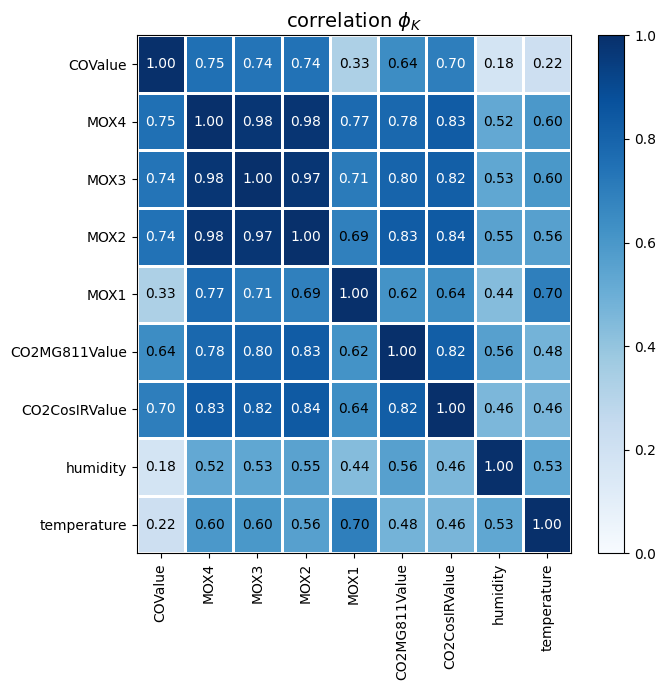

In [5]:
phik_coefs = df_gas[features].phik_matrix(interval_cols=features)
plot_correlation_matrix(phik_coefs.values, x_labels=phik_coefs.columns, y_labels=phik_coefs.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$',
                        figsize=(7,7))
plt.show()

Из иллюстрации заметна очень сильная корреляция между показателями датчиков оксида металла (2,3,4) между собой.Также значения этих датчиков коррелируют с значениями датчиков углекислого газа и угарного газа.

Также можно отметить существенную корреляцию между показателями датчика температуры и показателями датчика оксида металла 1, а также временем суток.

Теперь посмотрим на то, есть ли комбинации признаков с линейной зависимостью.

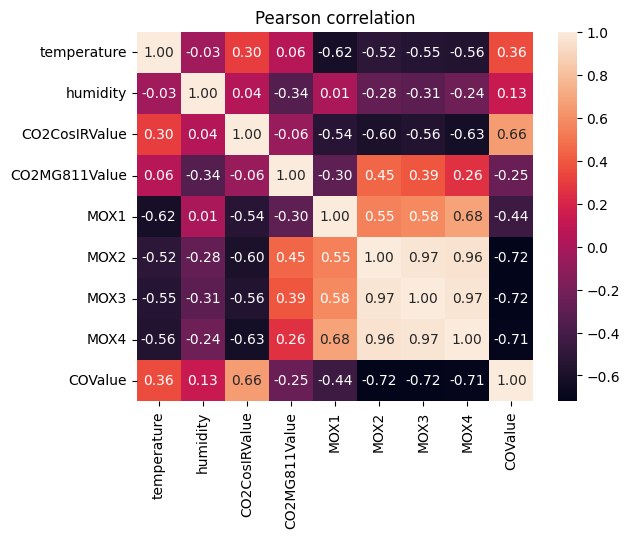

In [6]:
sns.heatmap(df_gas[features].corr(), annot=True, fmt=".2f")
plt.title("Pearson correlation", fontsize = 12)
plt.show()

Из графика видно, что показатели датчиков оксида металла (2, 3, 4) сильно линейно коррелируют между собой, впоследствии этот факт можно использовать, что применить к этим признакам PCA, не боясь потерять много информации.

Проверим, оказывает ли жизнедеятельность человека и время суток какой-то вклад на показания датчиков. Для этого выберем 2 часа в сутках, между которыми пролегает большой промежуток времени, например, ```10``` и ```22``` часа. 

Преполагается, что к 10 утра пожилой человек успеет проснуться и проветрить помещение, а к 22 часам в помещении накопятся следы его жизнедеятельности, которые и зафиксируют датчики. Профильтруем данные, соответсвующие данным моментам времени,

и сравним результаты для двух выборок: когда в доме кто-то жил и когда он был необитаем.

Предварительно отмасштрабируем признаки и применим PCA к показателям датчиков оксида металла.

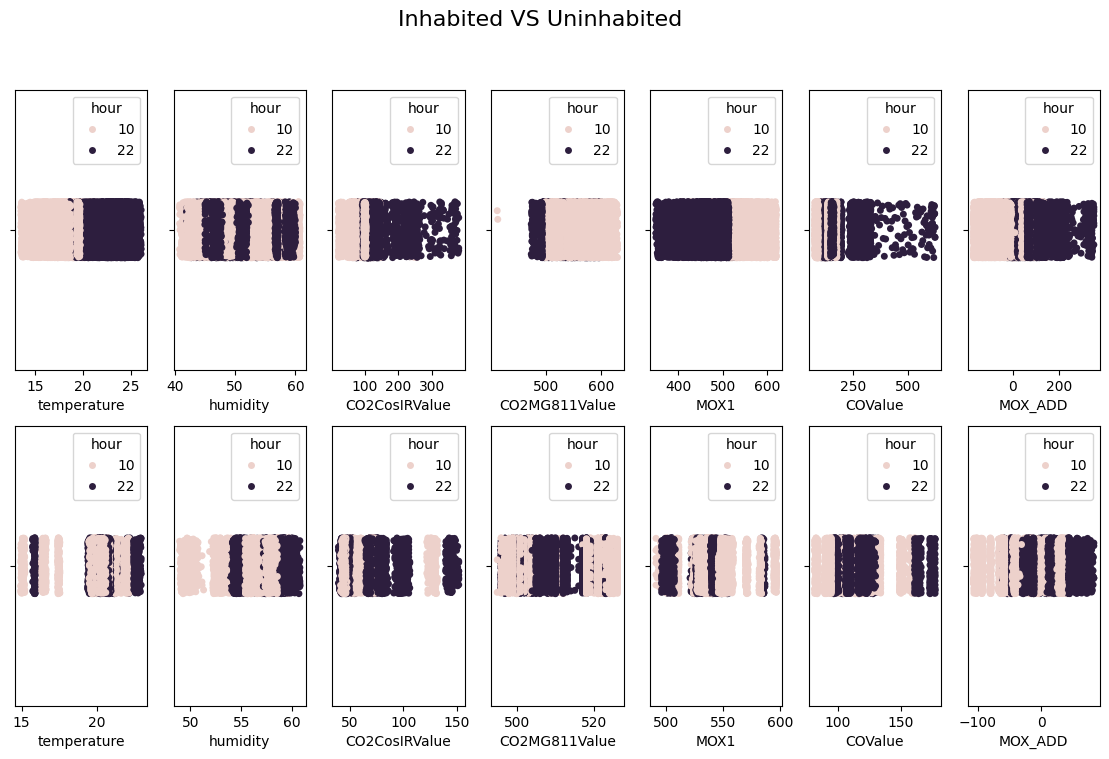

In [7]:
pca = PCA(n_components=1)

df_gas['MOX_ADD'] = pca.fit_transform(df_gas[['MOX2', 'MOX3', 'MOX4']].values)
joblib.dump(pca, '../models/pca.joblib')
df_gas.drop(['MOX2', 'MOX3', 'MOX4'], axis=1, inplace=True)

features.append('MOX_ADD')
features.remove('MOX2')
features.remove('MOX3')
features.remove('MOX4')

fig, axs = plt.subplots(2, 7, figsize=(14, 8))
fig.suptitle("Inhabited VS Uninhabited", fontsize=16)

for i in range(len(features)):
    sns.stripplot(data=df_gas[df_gas['hour'].isin([10, 22]) & (df_gas['inhabited'] == 1)], x=features[i], hue='hour', orient='h', ax=axs[0, i])
    sns.stripplot(data=df_gas[df_gas['hour'].isin([10, 22]) & (df_gas['inhabited'] == 0)], x=features[i], hue='hour', orient='h', ax=axs[1, i])

plt.show()

Из иллюстраций можно сделать вывод, что на значения датчиков влияет как время суток, так и присутствие человека. Во-первых, для большинства признаков можно сегментировать значения на основании времени суток при условии проживания человека, во-вторых размахи значений различаются для ситуаций, когда в доме кто-то проживает, и когда нет.

Посмотрим на дисперсию центрированных значений признаков для двух выборок.

In [8]:
features_var = pd.DataFrame()
inhabited_feature_vars = []
uninhabited_feature_vars = []

for feature in features:
    inhabited_feature_vars.append(round(np.var(df_gas[df_gas['inhabited'] == 1][feature]-df_gas[df_gas['inhabited'] == 1][feature].mean()), 2))
    uninhabited_feature_vars.append(round(np.var(df_gas[df_gas['inhabited'] == 0][feature]-df_gas[df_gas['inhabited'] == 0][feature].mean()), 2))

features_var['Признак'] = features
features_var['Жилой'] = inhabited_feature_vars
features_var['Нежилой'] = uninhabited_feature_vars

features_var.head(n=10)

,Признак,Жилой,Нежилой
0,temperature,6.00,1.97
1,humidity,16.38,5.84
2,CO2CosIRValue,1461.52,527.58
3,CO2MG811Value,1242.98,85.25
4,MOX1,2527.80,456.45
5,COValue,1466.89,479.78
6,MOX_ADD,4506.12,1625.20


Как и ожидалось, в нежилом доме значения признаков обладаются меньшим разбросом.

### Стратегия определения аномалий

Будем считать что в доме происходит что-то тревожное, если хотя бы один из датчиков показывает аномальное значения. Аномальными значениями будем считать выбросы, то есть значения которые лежат вне промежутка [0.25 квантиль - 1.5 мкр, 0.75 квантиль + 1.5 мкр], где мкр - межквартильный размах. Так как мы собираемся искать аномалии для случаев, когда в доме кто-то живет, будем брать соответствующую выборку для вычисления границ, с которых начинаются выбросы. Для выборки, когда дом пустовал, будем считать, что аномалий нет. Посмотрим на ящики с усами для признаков в разбивке по часам (0, 3, 6, 9, 12, 15, 18, 21).

In [9]:
HOURS = list(range(0, 21+1, 3))

In [10]:
def boxplot_figure(data, title, features, hours, hue='inhabited', figsize=(16, 8), fontsize=16):

    fig, axs = plt.subplots(len(features), len(hours), figsize=figsize)
    fig.suptitle(title, fontsize=fontsize)

    for i in range(len(hours)):
        for j in range(len(features)):
            sns.boxplot(data=data[data['hour'] == hours[i]], x=features[j], hue=hue, flierprops={"marker": "x"}, ax=axs[j, i])
            if j == 0:
                axs[j, i].set_title(f"{hours[i]} hour")  

    plt.show()

#### Температура и влажность

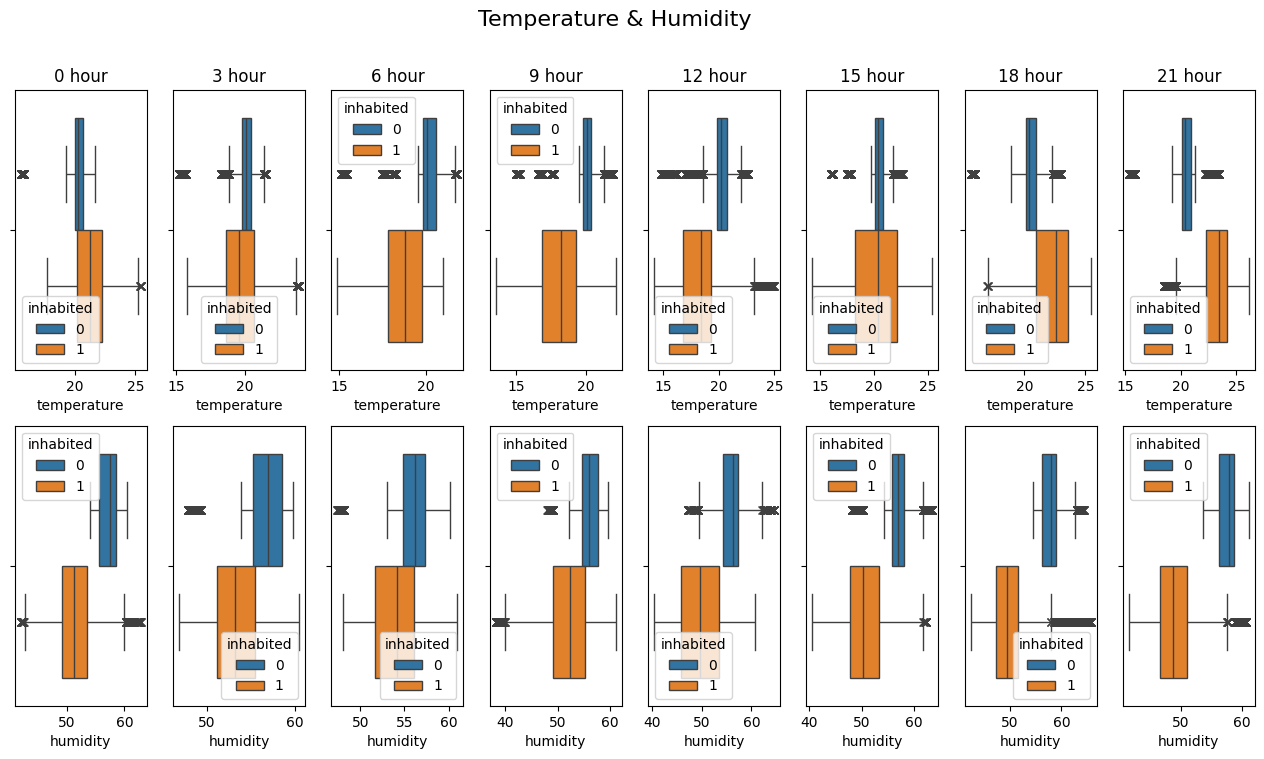

In [11]:
boxplot_figure(data=df_gas, title="Temperature & Humidity", features=['temperature', 'humidity'], hours=HOURS)

Из графика видно, что выбросов в температуре в среднем по сравнению с влажностью больше и они присутствуют для каждого выбранного часа.

#### Датчики углекислого и угарного газа

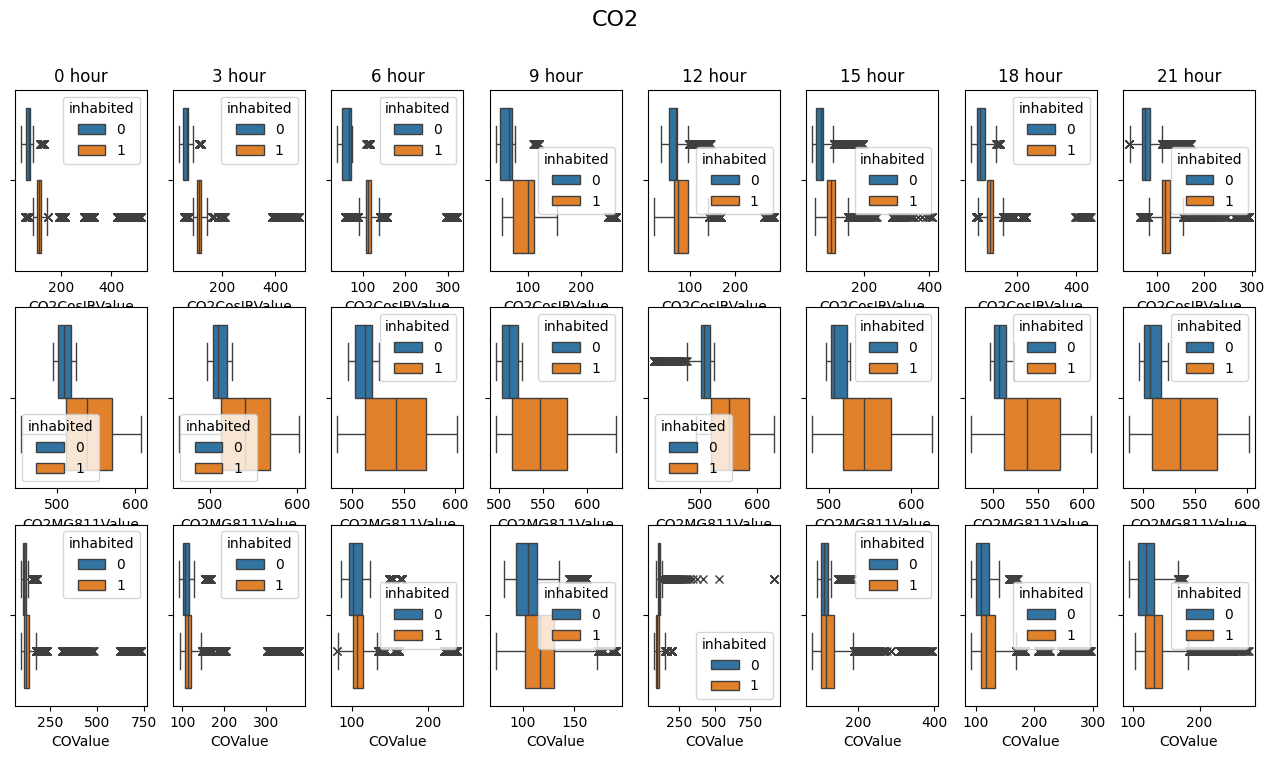

In [13]:
boxplot_figure(data=df_gas, title="CO2", features=['CO2CosIRValue', 'CO2MG811Value', 'COValue'], hours=HOURS)

Для CO2CosIRValue и COValue выбросы есть для каждого часа, а для CO2MG811Value их практически нет.

#### Датчики оксида металла

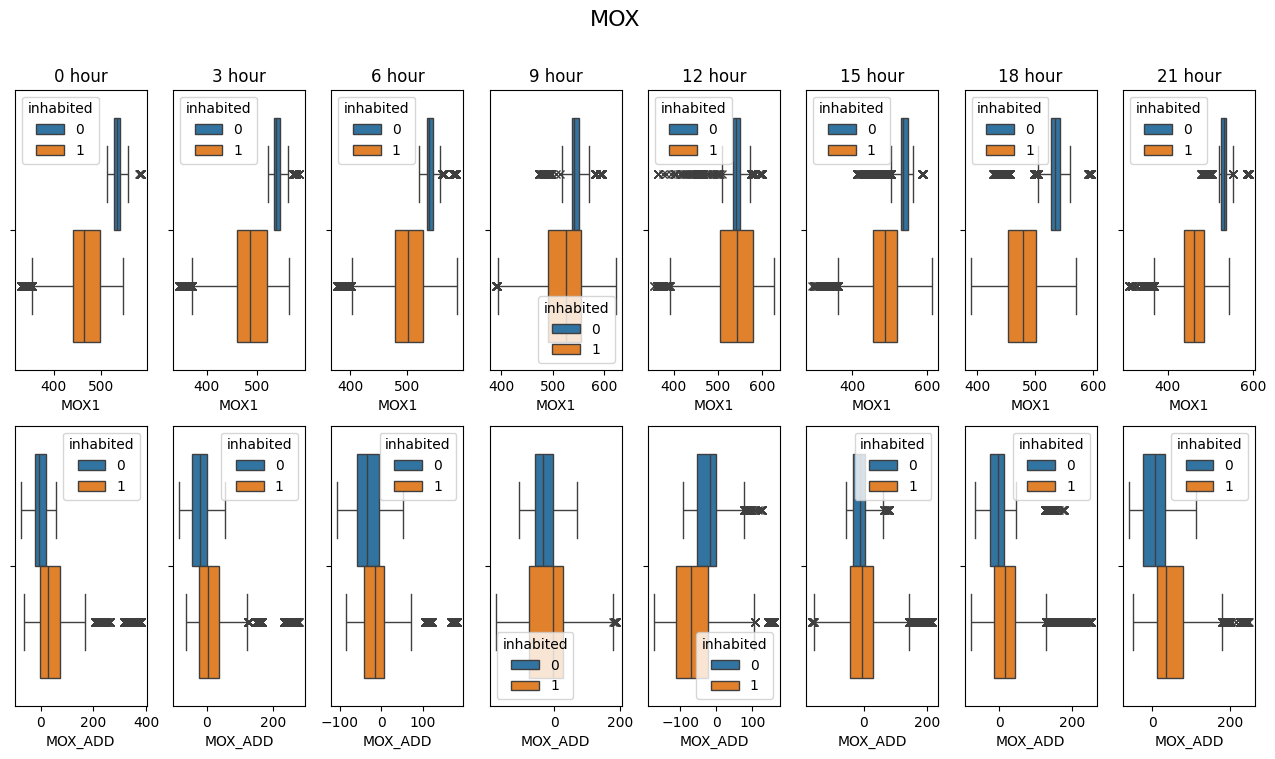

In [12]:
boxplot_figure(data=df_gas, title="MOX", features=['MOX1', 'MOX_ADD'], hours=HOURS)

Есть выбросы для обоих датчиков, но их немного.

### Проставим метки аномалия/нет аномалии

In [13]:
df_gas['anomaly'] = 0

Найдем границы невыбросов для каждого признака.

In [14]:
df_inhabited = df_gas[df_gas.inhabited == 1]

In [15]:
feature_hour_bounds = {}

for h in range(24):
    for feature in features:
        vals = df_inhabited[df_inhabited.hour == h][feature]
        iqr = np.percentile(vals, 75) - np.percentile(vals, 25)
        down = np.percentile(vals, 25) - 1.5 * iqr
        up = np.percentile(vals, 75) + 1.5 * iqr
        feature_hour_bounds[(h, feature)] = (down, up)


In [16]:
for i in range(len(df_gas)):
    if df_gas.iloc[i].inhabited:
        h = df_gas.iloc[i].hour
        for feature in features:        
            key = (h, feature)
            val = df_gas.iloc[i][feature]
            down, up = feature_hour_bounds[key]
            if val <= down or val >= up:
                df_gas.iloc[i, df_gas.columns.get_loc('anomaly')] = 1
                break 

In [17]:
print(f'Доля аномальных часов за все время: {round(len(df_gas[df_gas.anomaly == 1]) / len(df_gas) * 100, 2)} %')

Доля аномальных часов за все время: 10.45 %


### Модели

Рассмотрим 3 модели:

* случайный лес
* градиентный бустинг (Sklearn)
* градиентный бустинг (Catboost) 

В качестве метрики будем использовать balanced_accuracy_score, так как есть сильный дисбаланс классов (аномалий в разы меньше).

### Разобьем данные на трейн и тест

Чтобы избежать data leak, важно разбивать так, что показатели, собранные для одного дня, не попали одновременно в трейн и тест. Отберем в тест 15 % наблюдений.

In [18]:
df_uninhabited = df_gas[df_gas.inhabited == 0]

train_inhabited_idxs = df_gas[df_gas.day <= df_inhabited.day.quantile(0.85)].index
test_inhabited_idxs = df_gas[(df_gas.day > df_inhabited.day.quantile(0.85)) & (df_gas.day <= df_inhabited.day.quantile(1.))].index

train_uninhabited_idxs = df_gas[(df_gas.day >= df_uninhabited.day.quantile(0.)) & (df_gas.day <= df_uninhabited.day.quantile(0.85))].index
test_uninhabited_idxs = df_gas[df_gas.day > df_uninhabited.day.quantile(0.85)].index

train_idxs = [*train_inhabited_idxs, *train_uninhabited_idxs]
test_idxs = [*test_inhabited_idxs, *test_uninhabited_idxs]

In [19]:
random.shuffle(train_idxs)
random.shuffle(test_idxs)

In [20]:
X, y = df_gas.drop(['anomaly', 'day'], axis=1), df_gas.anomaly
X_train, X_test, y_train, y_test = X.loc[train_idxs], X.loc[test_idxs], y.loc[train_idxs], y.loc[test_idxs], 

#### Случайный лес

In [24]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)

RandomForestClassifier()

In [25]:
y_pred = clf_rf.predict(X_test)
print(f'Balanced accuracy для случайного леса: {round(balanced_accuracy_score(y_test, y_pred) * 100, 2)} %')

Balanced accuracy для случайного леса: 60.67 %


#### Градиентный бустинг (Sklearn)

In [26]:
clf_sk_gb = GradientBoostingClassifier()
clf_sk_gb.fit(X_train, y_train)

GradientBoostingClassifier()

In [27]:
y_pred = clf_sk_gb.predict(X_test)
print(f'Balanced accuracy для Sklearn градиентного бустинга: {round(balanced_accuracy_score(y_test, y_pred) * 100, 2)} %')

Balanced accuracy для Sklearn градиентного бустинга: 68.55 %


#### Градиентный бустинг (Catboost)

In [28]:
clf_catboost = CatBoostClassifier()
clf_catboost.fit(X_train, y_train, verbose=0)

In [29]:
y_pred = clf_catboost.predict(X_test)
print(f'Balanced accuracy для Catboost градиентного бустинга: {round(balanced_accuracy_score(y_test, y_pred) * 100, 2)} %')

Balanced accuracy для Catboost градиентного бустинга: 61.26 %


#### Топ моделей:

1. градиентный бустинг (Sklearn)
2. градиентный бустинг (Catboost)
3. случайный лес

Обучим модели на всей выборке и сохраним.

In [30]:
clf_sk_gb = GradientBoostingClassifier()
clf_sk_gb.fit(X, y)
joblib.dump(clf_sk_gb, '../models/sklearn_gb.joblib')

clf_catboost = CatBoostClassifier()
clf_catboost.fit(X, y, verbose=0)
joblib.dump(clf_catboost, '../models/catboost.joblib')

clf_rf = RandomForestClassifier()
clf_rf.fit(X, y)
joblib.dump(clf_rf, '../models/random_forest.joblib')

['../models/random_forest.joblib']

#### Бизнес-логика модели

Чем выше модель в топе, тем дороже стоит ее предсказание. 

1. градиентный бустинг (Sklearn) - 15 кредитов
2. градиентный бустинг (Catboost) - 7 кредитов
3. случайный лес - 5 кредитов

Выбранная модель будет предсказывать не наличие аномалии, а уверенность в том, что аномалия есть (вероятность), и на основе этой вероятности отправлять соответствующее сообщение:

1. Вероятность < 0.5 -> "OK"
2. 0.5 <= Вероятность < 0.8 -> "WARNING"
3. Вероятность >= 0.8 -> "DANGER"